# Análisis de Series de Tiempo II

### Búsqueda automática de hiperparámetros con Optuna
---




In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colores import colores
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import random
import os


1. Importar dataset

In [73]:
# Temperaturas diurnas (diarias)
df_d_diaria = pd.read_csv("csv/ts_imputado_bilstm.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })

df_d_diaria.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,26.323536,17.944593,1,8.378943
5,2020-01-06,26.860825,22.411600,1,4.449224
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,27.809013,23.053133,1,4.755880
8,2020-01-09,28.286922,23.420776,1,4.866146
9,2020-01-10,27.450967,22.472114,1,4.978853


2. Preparación de datos para entrenamiento

In [74]:
df_serie = df_d_diaria[['fecha','delta']]
df_serie = df_serie.set_index('fecha')
df_serie.index = pd.to_datetime(df_serie.index)
df_serie.head()

,delta
fecha,
2020-01-01,1.767079
2020-01-02,4.853032
2020-01-03,3.961601
2020-01-04,7.371023
2020-01-05,8.378943


In [75]:
train_size = int(len(df_serie) * 0.8)  # 80% entrenamiento, 20% test
train_size

1461

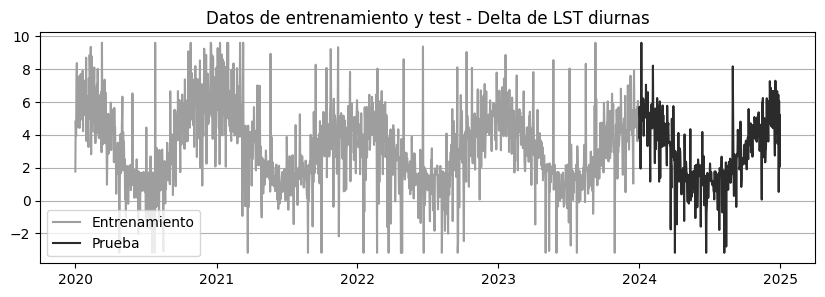

In [76]:
train = df_serie['delta'].iloc[:train_size]
test = df_serie['delta'].iloc[train_size:]

plt.figure(figsize=(10, 3))
plt.plot(train, label='Entrenamiento', color=colores['train'])
plt.plot(test, label='Prueba', color=colores['test'])
#plt.legend()
plt.legend(loc='lower left')

plt.grid(axis='y')
plt.title('Datos de entrenamiento y test - Delta de LST diurnas')
plt.show()

In [77]:
# Incluimos (opcionalmente) características estacionales (seno y coseno)
df_lstm = df_serie.copy()
use_seasonal_features = False  # False: usar solo el dato delta temperatura
if use_seasonal_features:
    df_lstm['semana_del_año'] = df_lstm.index.isocalendar().week
    df_lstm['sin_semana'] = np.sin(2 * np.pi * df_lstm['semana_del_año'] / 52)
    df_lstm['cos_semana'] = np.cos(2 * np.pi * df_lstm['semana_del_año'] / 52)
    data_to_scale = df_lstm[['delta', 'sin_semana', 'cos_semana']].values
else:
    data_to_scale = df_lstm[['delta']].values

In [78]:
data_min = data_to_scale.min()
data_max = data_to_scale.max()
print(f"Datos sin escalar: [{data_min:.4f}, {data_max:.4f}]")

Datos sin escalar: [-3.1822, 9.6100]


In [79]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_to_scale)
print(f"Datos escalados: [{data_scaled.min():.4f}, {data_scaled.max():.4f}]")

Datos escalados: [-1.0000, 1.0000]


In [80]:
# Crear secuencias
def create_sequences(data, seq_length, target_idx=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento y prueba
seq_length = 182  # 1/2 año de datos
X, y = create_sequences(data_scaled, seq_length, target_idx=0)
X_train, y_train = X[:train_size - seq_length], y[:train_size - seq_length]
X_test, y_test = X[train_size - seq_length:], y[train_size - seq_length:]


---
### Optimización de hiperparámetros

1. Seeds para reproducibilidad

In [81]:
seed = 42
def set_seed(seed=seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    sampler = TPESampler(seed=seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
   
    return sampler

In [84]:
# Ejecutar Optuna
def run_study(nombre_modelo:str, objective=objective, direction="minimize", nro_trials=20, sampler=sampler):
    study = optuna.create_study(direction=direction, sampler=sampler,)
    study.optimize(objective, n_trials=20, timeout=None, show_progress_bar=True)  # 20 experimentos

    best_mae = study.best_value
    best_params = study.best_params

    # Mejor resultado
    print(f"\nResultados para {nombre_modelo}:\n")
    print("Mejor MAE:", best_mae)
    print("Mejores params:", best_params)

2. Búsqueda de mejores hiperparámetros para Holt-Winters

In [87]:
# Definir experimentos con Optuna

sampler = set_seed(42)

def objective(trial: Trial):

    # Hyperparámetros
    trend     = trial.suggest_categorical("trend", ["add", "mul", None])
    seasonal  = trial.suggest_categorical("seasonal", ["add", "mul", None])
    use_boxcox = trial.suggest_categorical("use_boxcox", [True, False, "log"])
    
    alpha = trial.suggest_float("alpha",  0.01, 0.99)   # smoothing_level  (β0)
    beta  = trial.suggest_float("beta",   0.01, 0.99)   # smoothing_trend  (β)
    gamma = trial.suggest_float("gamma",  0.01, 0.99)   # smoothing_seasonal (γ)
    phi   = trial.suggest_float("phi",    0.9, 1.0)     # damping (if trend)

    damped = trial.suggest_categorical("damped_trend", [True, False])
    seasonal_periods = 365

    # Armar y entrenar el modelo
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            damped_trend=damped,
            use_boxcox=use_boxcox,
            initialization_method="heuristic"
        )
        
        fit = model.fit(
            smoothing_level=alpha,
            smoothing_trend=beta if trend is not None else None,
            smoothing_seasonal=gamma if seasonal is not None else None,
            damping_trend=phi if damped else None,
            use_brute=False,
            optimized=True
        )

        # Forecast + computar error
        forecast = fit.forecast(len(test))
        mae = mean_absolute_error(test, forecast)

        return mae

    except Exception as e:
        # Rechazar experimento si se da una configuración no válida
        return np.inf

run_study("Holt-Winters", objective=objective, direction="minimize", nro_trials=20, sampler=sampler)

[I 2025-12-11 10:53:03,097] A new study created in memory with name: no-name-2f1e6850-72e1-4628-b66d-f2a90ae235d5
Best trial: 17. Best value: 1.26599: 100%|██████████| 20/20 [00:00<00:00, 99.41it/s] 

[I 2025-12-11 10:53:03,106] Trial 0 finished with value: inf and parameters: {'trend': 'mul', 'seasonal': 'add', 'use_boxcox': False, 'alpha': 0.7039111262401245, 'beta': 0.030172804409886397, 'gamma': 0.9605116551187545, 'phi': 0.9832442640800422, 'damped_trend': True}. Best is trial 0 with value: inf.
[I 2025-12-11 10:53:03,108] Trial 1 finished with value: inf and parameters: {'trend': None, 'seasonal': None, 'use_boxcox': 'log', 'alpha': 0.4569485845326952, 'beta': 0.7794724421651533, 'gamma': 0.20568030651519253, 'phi': 0.9514234438413611, 'damped_trend': True}. Best is trial 0 with value: inf.
[I 2025-12-11 10:53:03,110] Trial 2 finished with value: inf and parameters: {'trend': 'add', 'seasonal': 'mul', 'use_boxcox': 'log', 'alpha': 0.4413494438648093, 'beta': 0.12959747014788325, 'gamma': 0.49527337190904475, 'phi': 0.9034388521115219, 'damped_trend': True}. Best is trial 0 with value: inf.
[I 2025-12-11 10:53:03,134] Trial 3 finished with value: 41.863138917073734 and paramete

3. Búsqueda de mejores hiperparámetros para el modelo Transformer

In [95]:
# Definición del modelo
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Crea matriz de positional encoding (sinusoide fija)
        pe = np.zeros((seq_len, d_model))
        position = np.arange(0, seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]  # (1, seq_len, d_model)
        self.pe = tf.constant(pe, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]


def build_transformer(d_model=64, n_heads=4, n_layers=2, ff_dim=128, dropout=0.1, final_dropout=0.2, lr=1e-4):
    seq_length = 182
    n_features = X_train.shape[2]  # 1 o 3
    tf.keras.mixed_precision.set_global_policy('float32')

    inputs = Input(shape=(seq_length, n_features))
    
    # 1. Proyección lineal a d_model
    x = layers.Dense(d_model)(inputs)
    
    # 2. POSITIONAL ENCODING
    x = PositionalEncoding(seq_length, d_model)(x)
    
    # 3. Bloques Transformer
    for _ in range(n_layers):
        # Multi-Head Self Attention
        attn_output = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout
        )(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed Forward
        ff = layers.Dense(ff_dim, activation='relu')(x1)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(dropout)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x1 + ff)
    
    # 4. Salida
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(final_dropout)(x)
    outputs = layers.Dense(1, dtype='float32')(x)   
    
    model = Model(inputs, outputs)
    
    # Compilación
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


In [96]:
sampler = set_seed(42)

def objective(trial: Trial):

    # Hiperparámetros
    d_model = trial.suggest_categorical("d_model", [48, 64, 80, 96, 128])
    n_heads = trial.suggest_categorical("n_heads", [4, 8])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    ff_dim   = trial.suggest_int("ff_dim", 96, 256, step=32)
    dropout  = trial.suggest_float("dropout", 0.05, 0.2, step=0.05)
    final_dropout = trial.suggest_float("final_dropout", 0.1, 0.4, step=0.1)
    lr       = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    
    # Armar el modelo
    model = build_transformer(d_model, n_heads, n_layers, ff_dim,
                              dropout, final_dropout, lr)
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=0
        ),
        
    ]

    # Entrenar
    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=100,
              batch_size=batch_size,
              callbacks=callbacks,
              verbose=0)


    # Predecir con el set de test 
    y_pred_scaled = model.predict(X_test, verbose=0).flatten()
    y_test_scaled = y_test

    # Inverse transform para volver a los rangos originales
    y_pred = scaler.inverse_transform(
        np.concatenate([y_pred_scaled.reshape(-1,1),
                        np.zeros((len(y_pred_scaled), data_to_scale.shape[1]-1))], axis=1)
    )[:, 0]

    y_true = scaler.inverse_transform(
        np.concatenate([y_test_scaled.reshape(-1,1),
                        np.zeros((len(y_test_scaled), data_to_scale.shape[1]-1))], axis=1)
    )[:, 0]

    # Error
    mae  = mean_absolute_error(y_true, y_pred)
    trial.set_user_attr("mae", mae)
    
    return mae   

run_study("Transformer", objective=objective, direction="minimize", nro_trials=20, sampler=sampler)


[I 2025-12-11 13:29:40,816] A new study created in memory with name: no-name-49bfc497-266d-495b-808f-1f5413143d56
Best trial: 0. Best value: 1.09067:   5%|▌         | 1/20 [03:52<1:13:35, 232.37s/it]

[I 2025-12-11 13:33:33,267] Trial 0 finished with value: 1.0906724267516403 and parameters: {'d_model': 64, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 192, 'dropout': 0.15000000000000002, 'final_dropout': 0.1, 'lr': 0.004353010439152428, 'batch_size': 16}. Best is trial 0 with value: 1.0906724267516403.


Best trial: 1. Best value: 0.979773:  10%|█         | 2/20 [05:21<44:29, 148.32s/it]  

[I 2025-12-11 13:35:02,749] Trial 1 finished with value: 0.9797726472570973 and parameters: {'d_model': 80, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 160, 'dropout': 0.1, 'final_dropout': 0.4, 'lr': 0.00012540578430226165, 'batch_size': 32}. Best is trial 1 with value: 0.9797726472570973.


Best trial: 1. Best value: 0.979773:  15%|█▌        | 3/20 [06:27<31:19, 110.54s/it]

[I 2025-12-11 13:36:08,340] Trial 2 finished with value: 0.9973358506888502 and parameters: {'d_model': 128, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 224, 'dropout': 0.1, 'final_dropout': 0.1, 'lr': 0.0004890168508329705, 'batch_size': 32}. Best is trial 1 with value: 0.9797726472570973.


Best trial: 1. Best value: 0.979773:  20%|██        | 4/20 [10:02<40:31, 151.96s/it]

[I 2025-12-11 13:39:43,794] Trial 3 finished with value: 1.0020398660705383 and parameters: {'d_model': 48, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 256, 'dropout': 0.15000000000000002, 'final_dropout': 0.4, 'lr': 7.515450322528411e-05, 'batch_size': 64}. Best is trial 1 with value: 0.9797726472570973.


Best trial: 1. Best value: 0.979773:  25%|██▌       | 5/20 [17:31<1:04:42, 258.82s/it]

[I 2025-12-11 13:47:12,093] Trial 4 finished with value: 0.9964744363996683 and parameters: {'d_model': 80, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 96, 'dropout': 0.2, 'final_dropout': 0.4, 'lr': 0.00012485368572526373, 'batch_size': 32}. Best is trial 1 with value: 0.9797726472570973.


Best trial: 1. Best value: 0.979773:  30%|███       | 6/20 [18:15<43:23, 185.99s/it]  

[I 2025-12-11 13:47:56,718] Trial 5 finished with value: 0.9815861840835379 and parameters: {'d_model': 64, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 96, 'dropout': 0.1, 'final_dropout': 0.2, 'lr': 0.0014394028591544622, 'batch_size': 32}. Best is trial 1 with value: 0.9797726472570973.


Best trial: 1. Best value: 0.979773:  35%|███▌      | 7/20 [21:11<39:33, 182.55s/it]

[I 2025-12-11 13:50:52,188] Trial 6 finished with value: 0.9873012116098078 and parameters: {'d_model': 128, 'n_heads': 8, 'n_layers': 2, 'ff_dim': 96, 'dropout': 0.05, 'final_dropout': 0.1, 'lr': 0.000937110549277785, 'batch_size': 64}. Best is trial 1 with value: 0.9797726472570973.


Best trial: 7. Best value: 0.972666:  40%|████      | 8/20 [24:37<38:02, 190.22s/it]

[I 2025-12-11 13:54:18,822] Trial 7 finished with value: 0.9726660047020298 and parameters: {'d_model': 80, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 224, 'dropout': 0.15000000000000002, 'final_dropout': 0.4, 'lr': 0.0020244831112923374, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  45%|████▌     | 9/20 [28:44<38:05, 207.81s/it]

[I 2025-12-11 13:58:25,316] Trial 8 finished with value: 0.9984942100927552 and parameters: {'d_model': 64, 'n_heads': 8, 'n_layers': 3, 'ff_dim': 96, 'dropout': 0.15000000000000002, 'final_dropout': 0.2, 'lr': 0.0001390546848963277, 'batch_size': 64}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  50%|█████     | 10/20 [31:29<32:25, 194.54s/it]

[I 2025-12-11 14:01:10,133] Trial 9 finished with value: 1.1246005893606579 and parameters: {'d_model': 128, 'n_heads': 4, 'n_layers': 2, 'ff_dim': 128, 'dropout': 0.1, 'final_dropout': 0.1, 'lr': 0.0008281302946667976, 'batch_size': 16}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  55%|█████▌    | 11/20 [34:34<28:44, 191.65s/it]

[I 2025-12-11 14:04:15,222] Trial 10 finished with value: 1.0729502823666395 and parameters: {'d_model': 96, 'n_heads': 8, 'n_layers': 2, 'ff_dim': 256, 'dropout': 0.2, 'final_dropout': 0.30000000000000004, 'lr': 0.004330769658428382, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  60%|██████    | 12/20 [35:28<19:57, 149.72s/it]

[I 2025-12-11 14:05:09,047] Trial 11 finished with value: 0.9995680477514239 and parameters: {'d_model': 80, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 160, 'dropout': 0.05, 'final_dropout': 0.4, 'lr': 0.00025459863272284724, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  65%|██████▌   | 13/20 [36:18<13:57, 119.65s/it]

[I 2025-12-11 14:05:59,491] Trial 12 finished with value: 0.9861116455094925 and parameters: {'d_model': 80, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 192, 'dropout': 0.15000000000000002, 'final_dropout': 0.30000000000000004, 'lr': 0.0018020913027184766, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  70%|███████   | 14/20 [38:59<13:12, 132.02s/it]

[I 2025-12-11 14:08:40,119] Trial 13 finished with value: 0.9881622713775696 and parameters: {'d_model': 80, 'n_heads': 4, 'n_layers': 2, 'ff_dim': 160, 'dropout': 0.1, 'final_dropout': 0.30000000000000004, 'lr': 0.0003271053657579637, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  75%|███████▌  | 15/20 [41:24<11:19, 135.93s/it]

[I 2025-12-11 14:11:05,087] Trial 14 finished with value: 0.9844956494300937 and parameters: {'d_model': 80, 'n_heads': 8, 'n_layers': 2, 'ff_dim': 224, 'dropout': 0.05, 'final_dropout': 0.4, 'lr': 0.0023321838809476384, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  80%|████████  | 16/20 [48:10<14:29, 217.38s/it]

[I 2025-12-11 14:17:51,606] Trial 15 finished with value: 1.0146569287476983 and parameters: {'d_model': 96, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 224, 'dropout': 0.2, 'final_dropout': 0.30000000000000004, 'lr': 5.57377676165724e-05, 'batch_size': 16}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  85%|████████▌ | 17/20 [49:37<08:54, 178.14s/it]

[I 2025-12-11 14:19:18,505] Trial 16 finished with value: 0.9782361375366754 and parameters: {'d_model': 48, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 160, 'dropout': 0.15000000000000002, 'final_dropout': 0.4, 'lr': 0.00019134914211708581, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  90%|█████████ | 18/20 [51:55<05:32, 166.13s/it]

[I 2025-12-11 14:21:36,670] Trial 17 finished with value: 0.9860380341250485 and parameters: {'d_model': 48, 'n_heads': 4, 'n_layers': 2, 'ff_dim': 192, 'dropout': 0.15000000000000002, 'final_dropout': 0.4, 'lr': 0.00023935158893204347, 'batch_size': 32}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666:  95%|█████████▌| 19/20 [53:29<02:24, 144.33s/it]

[I 2025-12-11 14:23:10,230] Trial 18 finished with value: 1.007609169654825 and parameters: {'d_model': 48, 'n_heads': 8, 'n_layers': 2, 'ff_dim': 128, 'dropout': 0.2, 'final_dropout': 0.2, 'lr': 0.0005697771978435785, 'batch_size': 64}. Best is trial 7 with value: 0.9726660047020298.


Best trial: 7. Best value: 0.972666: 100%|██████████| 20/20 [54:23<00:00, 163.17s/it]

[I 2025-12-11 14:24:04,347] Trial 19 finished with value: 1.0103038382282665 and parameters: {'d_model': 48, 'n_heads': 4, 'n_layers': 1, 'ff_dim': 128, 'dropout': 0.15000000000000002, 'final_dropout': 0.30000000000000004, 'lr': 0.002827016057807196, 'batch_size': 16}. Best is trial 7 with value: 0.9726660047020298.

Resultados para Transformer:

Mejor MAE: 0.9726660047020298
Mejores params: {'d_model': 80, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 224, 'dropout': 0.15000000000000002, 'final_dropout': 0.4, 'lr': 0.0020244831112923374, 'batch_size': 32}


4. Búsqueda de mejores hiperparámetros para el modelo LSTM

In [91]:
sampler = set_seed(42)

def objective(trial):

    units1     = trial.suggest_categorical("units1", [32, 48, 64, 96])        # Primera capa
    units2     = trial.suggest_categorical("units2", [16, 24, 32, 48])        # Segunda capa
    dropout1   = trial.suggest_float("dropout1", 0.1, 0.4, step=0.1)
    dropout2   = trial.suggest_float("dropout2", 0.1, 0.5, step=0.1)
    lr         = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    n_layers   = trial.suggest_categorical("n_layers", [1, 2])

    # Armar modelo
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))

    model.add(LSTM(units1, activation='tanh', return_sequences=(n_layers == 2)))
    model.add(Dropout(dropout1))

    if n_layers == 2:
        model.add(LSTM(units2, activation='tanh'))
        model.add(Dropout(dropout2))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )

    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        shuffle=False,
        epochs=100,                    
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )


    y_pred_scaled = model.predict(X_test, verbose=0).flatten()
    y_pred = scaler.inverse_transform(
        np.column_stack([y_pred_scaled, np.zeros((len(y_pred_scaled), data_to_scale.shape[1]-1))])
    )[:, 0]
    y_true = scaler.inverse_transform(
        np.column_stack([y_test, np.zeros((len(y_test), data_to_scale.shape[1]-1))])
    )[:, 0]

    mae = mean_absolute_error(y_true, y_pred)
    trial.set_user_attr("test_mae", mae)

    return mae


run_study("LSTM", objective=objective, direction="minimize", nro_trials=20, sampler=sampler)  


[I 2025-12-11 11:47:01,494] A new study created in memory with name: no-name-ff18042a-35cc-47cb-b324-3f2ea035f097
Best trial: 0. Best value: 1.00733:   5%|▌         | 1/20 [03:06<59:08, 186.76s/it]

[I 2025-12-11 11:50:08,255] Trial 0 finished with value: 1.0073333931860704 and parameters: {'units1': 48, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'lr': 0.00010994335574766199, 'batch_size': 16, 'n_layers': 2}. Best is trial 0 with value: 1.0073333931860704.


Best trial: 0. Best value: 1.00733:  10%|█         | 2/20 [03:22<25:55, 86.44s/it] 

[I 2025-12-11 11:50:24,467] Trial 1 finished with value: 1.0077165845167497 and parameters: {'units1': 48, 'units2': 16, 'dropout1': 0.2, 'dropout2': 0.4, 'lr': 0.00025081156860452336, 'batch_size': 32, 'n_layers': 1}. Best is trial 0 with value: 1.0073333931860704.


Best trial: 2. Best value: 1.00628:  15%|█▌        | 3/20 [06:53<40:29, 142.94s/it]

[I 2025-12-11 11:53:54,630] Trial 2 finished with value: 1.0062776295516938 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'lr': 0.00011715937392307068, 'batch_size': 16, 'n_layers': 2}. Best is trial 2 with value: 1.0062776295516938.


Best trial: 3. Best value: 1.00573:  20%|██        | 4/20 [08:29<33:12, 124.50s/it]

[I 2025-12-11 11:55:30,872] Trial 3 finished with value: 1.00573272163675 and parameters: {'units1': 64, 'units2': 16, 'dropout1': 0.1, 'dropout2': 0.1, 'lr': 0.00012315571723666037, 'batch_size': 32, 'n_layers': 1}. Best is trial 3 with value: 1.00573272163675.


Best trial: 3. Best value: 1.00573:  25%|██▌       | 5/20 [09:33<25:39, 102.65s/it]

[I 2025-12-11 11:56:34,769] Trial 4 finished with value: 1.0103382370654033 and parameters: {'units1': 96, 'units2': 24, 'dropout1': 0.1, 'dropout2': 0.5, 'lr': 0.002592475660475159, 'batch_size': 32, 'n_layers': 1}. Best is trial 3 with value: 1.00573272163675.


Best trial: 5. Best value: 1.00276:  30%|███       | 6/20 [10:00<17:58, 77.03s/it] 

[I 2025-12-11 11:57:02,085] Trial 5 finished with value: 1.0027617651713674 and parameters: {'units1': 32, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.00017345566642360953, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  35%|███▌      | 7/20 [10:23<12:49, 59.18s/it]

[I 2025-12-11 11:57:24,515] Trial 6 finished with value: 1.0049579976263958 and parameters: {'units1': 32, 'units2': 24, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.000661859559718348, 'batch_size': 16, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  40%|████      | 8/20 [11:58<14:09, 70.80s/it]

[I 2025-12-11 11:59:00,204] Trial 7 finished with value: 1.0059454070157203 and parameters: {'units1': 32, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.5, 'lr': 0.0004325207525386532, 'batch_size': 64, 'n_layers': 2}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  45%|████▌     | 9/20 [12:20<10:11, 55.57s/it]

[I 2025-12-11 11:59:22,277] Trial 8 finished with value: 1.0105270807525601 and parameters: {'units1': 48, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'lr': 0.0005336533066379613, 'batch_size': 16, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  50%|█████     | 10/20 [13:34<10:13, 61.32s/it]

[I 2025-12-11 12:00:36,477] Trial 9 finished with value: 1.0066232807033773 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'lr': 0.009360540102485375, 'batch_size': 64, 'n_layers': 2}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  55%|█████▌    | 11/20 [14:16<08:15, 55.11s/it]

[I 2025-12-11 12:01:17,501] Trial 10 finished with value: 1.0040747151757399 and parameters: {'units1': 32, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.1, 'lr': 0.0019062374828215129, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  60%|██████    | 12/20 [14:30<05:40, 42.62s/it]

[I 2025-12-11 12:01:31,544] Trial 11 finished with value: 1.0098049834070761 and parameters: {'units1': 32, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.1, 'lr': 0.0017175482489007374, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  65%|██████▌   | 13/20 [14:58<04:28, 38.43s/it]

[I 2025-12-11 12:02:00,333] Trial 12 finished with value: 1.0121544951294867 and parameters: {'units1': 32, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'lr': 0.004414973500475089, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  70%|███████   | 14/20 [15:24<03:27, 34.62s/it]

[I 2025-12-11 12:02:26,145] Trial 13 finished with value: 1.0074013380909805 and parameters: {'units1': 32, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.0012013116277075824, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  75%|███████▌  | 15/20 [16:08<03:06, 37.40s/it]

[I 2025-12-11 12:03:09,985] Trial 14 finished with value: 1.0065835764538762 and parameters: {'units1': 96, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.00026226452869618314, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  80%|████████  | 16/20 [16:34<02:15, 33.84s/it]

[I 2025-12-11 12:03:35,570] Trial 15 finished with value: 1.0118551057506706 and parameters: {'units1': 32, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'lr': 0.0031570283174644866, 'batch_size': 32, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  85%|████████▌ | 17/20 [17:00<01:34, 31.54s/it]

[I 2025-12-11 12:04:01,760] Trial 16 finished with value: 1.0035126485995687 and parameters: {'units1': 32, 'units2': 24, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.0014207218658021806, 'batch_size': 64, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  90%|█████████ | 18/20 [17:08<00:49, 24.67s/it]

[I 2025-12-11 12:04:10,442] Trial 17 finished with value: 1.006511688568154 and parameters: {'units1': 32, 'units2': 24, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.0008303788251629811, 'batch_size': 64, 'n_layers': 1}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 5. Best value: 1.00276:  95%|█████████▌| 19/20 [18:58<00:50, 50.24s/it]

[I 2025-12-11 12:06:00,251] Trial 18 finished with value: 1.0075071645706593 and parameters: {'units1': 96, 'units2': 24, 'dropout1': 0.2, 'dropout2': 0.4, 'lr': 0.0002753423170739044, 'batch_size': 64, 'n_layers': 2}. Best is trial 5 with value: 1.0027617651713674.


Best trial: 19. Best value: 0.99394: 100%|██████████| 20/20 [19:42<00:00, 59.15s/it]

[I 2025-12-11 12:06:44,483] Trial 19 finished with value: 0.9939401371554599 and parameters: {'units1': 32, 'units2': 24, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'lr': 0.0011982448134112169, 'batch_size': 64, 'n_layers': 1}. Best is trial 19 with value: 0.9939401371554599.

Resultados para LSTM:

Mejor MAE: 0.9939401371554599
Mejores params: {'units1': 32, 'units2': 24, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'lr': 0.0011982448134112169, 'batch_size': 64, 'n_layers': 1}


4. Búsqueda de mejores hiperparámetros para el modelo GRU

In [94]:
sampler = set_seed(42)

def objective(trial):
    
    units1     = trial.suggest_categorical("units1",     [32, 48, 64, 80])
    units2     = trial.suggest_categorical("units2",     [16, 24, 32, 48])
    dropout1   = trial.suggest_float(      "dropout1",   0.1, 0.4, step=0.1)
    dropout2   = trial.suggest_float(      "dropout2",   0.2, 0.5, step=0.1)
    lr         = trial.suggest_float(      "lr",         8e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    n_layers   = trial.suggest_categorical("n_layers",   [1, 2])   # 
   
    model = Sequential([
        Input(shape=(seq_length, 1)),
        GRU(units1, activation='tanh', return_sequences=(n_layers == 2)),
        Dropout(dropout1),
    ])

    if n_layers == 2:
        model.add(GRU(units2, activation='tanh'))
        model.add(Dropout(dropout2))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    try:
        model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.2,
            shuffle=False,
            callbacks=[early_stopping],
            verbose=0
        )
    except:
        return 1e6

    
    y_pred_scaled = model.predict(X_test, verbose=0).flatten()
    dummy = np.zeros((len(y_pred_scaled), data_to_scale.shape[1] - 1))
    y_pred = scaler.inverse_transform(np.column_stack([y_pred_scaled, dummy]))[:, 0]
    y_true = scaler.inverse_transform(np.column_stack([y_test, dummy]))[:, 0]

    mae = mean_absolute_error(y_true, y_pred)
    trial.set_user_attr("mae", mae)

    return mae

run_study("GRU", objective=objective, direction="minimize", nro_trials=20, sampler=sampler)  

[I 2025-12-11 12:10:23,256] A new study created in memory with name: no-name-aa0cfdc1-7109-44c3-b650-dbee725af632
Best trial: 0. Best value: 1.00645:   5%|▌         | 1/20 [06:17<1:59:35, 377.66s/it]

[I 2025-12-11 12:16:40,911] Trial 0 finished with value: 1.0064490218224853 and parameters: {'units1': 48, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'lr': 8.835961587392029e-05, 'batch_size': 16, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 0. Best value: 1.00645:  10%|█         | 2/20 [08:06<1:05:48, 219.38s/it]

[I 2025-12-11 12:18:29,496] Trial 1 finished with value: 1.0078792891908785 and parameters: {'units1': 80, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.0009580613713397409, 'batch_size': 64, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 0. Best value: 1.00645:  15%|█▌        | 3/20 [11:12<57:48, 204.03s/it]  

[I 2025-12-11 12:21:35,271] Trial 2 finished with value: 1.007327038735589 and parameters: {'units1': 32, 'units2': 16, 'dropout1': 0.1, 'dropout2': 0.5, 'lr': 0.0002790797476283617, 'batch_size': 16, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 0. Best value: 1.00645:  20%|██        | 4/20 [14:04<51:04, 191.54s/it]

[I 2025-12-11 12:24:27,658] Trial 3 finished with value: 1.0100101903879901 and parameters: {'units1': 48, 'units2': 16, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'lr': 0.0002965408231373435, 'batch_size': 16, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 0. Best value: 1.00645:  25%|██▌       | 5/20 [17:08<47:11, 188.76s/it]

[I 2025-12-11 12:27:31,484] Trial 4 finished with value: 1.0076627087848538 and parameters: {'units1': 48, 'units2': 24, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.0004516066854820385, 'batch_size': 32, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 0. Best value: 1.00645:  30%|███       | 6/20 [21:53<51:42, 221.60s/it]

[I 2025-12-11 12:32:16,815] Trial 5 finished with value: 1.0083841326881753 and parameters: {'units1': 80, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'lr': 0.0008680303643507904, 'batch_size': 16, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 0. Best value: 1.00645:  35%|███▌      | 7/20 [22:34<35:13, 162.56s/it]

[I 2025-12-11 12:32:57,825] Trial 6 finished with value: 1.011987251709126 and parameters: {'units1': 64, 'units2': 24, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.007121677503054263, 'batch_size': 64, 'n_layers': 2}. Best is trial 0 with value: 1.0064490218224853.


Best trial: 7. Best value: 1.00597:  40%|████      | 8/20 [23:55<27:20, 136.70s/it]

[I 2025-12-11 12:34:19,162] Trial 7 finished with value: 1.0059742275429255 and parameters: {'units1': 64, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.0009420655442125198, 'batch_size': 16, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  45%|████▌     | 9/20 [25:07<21:19, 116.35s/it]

[I 2025-12-11 12:35:30,774] Trial 8 finished with value: 1.0088612287929277 and parameters: {'units1': 80, 'units2': 16, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.0015180691073738472, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  50%|█████     | 10/20 [27:25<20:30, 123.05s/it]

[I 2025-12-11 12:37:48,820] Trial 9 finished with value: 1.0080295625306166 and parameters: {'units1': 48, 'units2': 16, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'lr': 0.0010630685907453063, 'batch_size': 32, 'n_layers': 2}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  55%|█████▌    | 11/20 [28:04<14:35, 97.27s/it] 

[I 2025-12-11 12:38:27,656] Trial 10 finished with value: 1.0063304501789216 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.0036153668108863907, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  60%|██████    | 12/20 [28:42<10:33, 79.13s/it]

[I 2025-12-11 12:39:05,288] Trial 11 finished with value: 1.0075364672425633 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.0053328421654925675, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  65%|██████▌   | 13/20 [29:20<07:47, 66.84s/it]

[I 2025-12-11 12:39:43,850] Trial 12 finished with value: 1.0073141992421137 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.003143764666983474, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  70%|███████   | 14/20 [29:56<05:45, 57.64s/it]

[I 2025-12-11 12:40:20,220] Trial 13 finished with value: 1.0104012169768875 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.0030376222192307124, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  75%|███████▌  | 15/20 [31:08<05:09, 61.85s/it]

[I 2025-12-11 12:41:31,847] Trial 14 finished with value: 1.010345477969584 and parameters: {'units1': 64, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'lr': 0.002404469910443385, 'batch_size': 16, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  80%|████████  | 16/20 [31:23<03:11, 47.82s/it]

[I 2025-12-11 12:41:47,091] Trial 15 finished with value: 1.0100340358959163 and parameters: {'units1': 32, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.2, 'lr': 0.00980952515288732, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  85%|████████▌ | 17/20 [33:22<03:27, 69.07s/it]

[I 2025-12-11 12:43:45,562] Trial 16 finished with value: 1.0068858810195591 and parameters: {'units1': 64, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.00012012735075162369, 'batch_size': 32, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  90%|█████████ | 18/20 [34:47<02:28, 74.01s/it]

[I 2025-12-11 12:45:11,081] Trial 17 finished with value: 1.0071518831430506 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'lr': 0.0005924548527163835, 'batch_size': 64, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597:  95%|█████████▌| 19/20 [35:33<01:05, 65.48s/it]

[I 2025-12-11 12:45:56,689] Trial 18 finished with value: 1.0073094600920658 and parameters: {'units1': 64, 'units2': 24, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'lr': 0.001863920940007776, 'batch_size': 128, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.


Best trial: 7. Best value: 1.00597: 100%|██████████| 20/20 [36:18<00:00, 108.91s/it]

[I 2025-12-11 12:46:41,452] Trial 19 finished with value: 1.0117375585690465 and parameters: {'units1': 32, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'lr': 0.004210048328853127, 'batch_size': 16, 'n_layers': 1}. Best is trial 7 with value: 1.0059742275429255.

Resultados para GRU:

Mejor MAE: 1.0059742275429255
Mejores params: {'units1': 64, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.0009420655442125198, 'batch_size': 16, 'n_layers': 1}
